## **Predicting Dyslexia Disease**

- This Notebook contains different AI Approaches i.e Deep Learning, Machine Learning & Transfer Learning in order to predict dylexia disease. 

- There are 2 types of dataset Train and Test each contains image dataset of english letters

### Import the Necessary Libraries For the Project

In [6]:
# import libraries
import pandas as pd
import numpy as np
import glob
import imageio as imageio
import matplotlib.pyplot as plt
import sklearn
import cv2
import os

In [7]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [8]:
project_path = "Data"

/tmp/ipykernel_9318/567847224.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(pic)


picture shape: (28, 28)


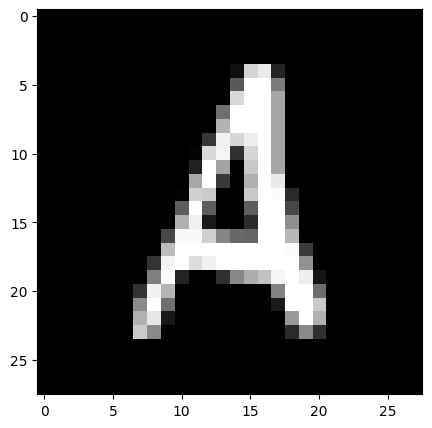

In [9]:
# load a picture
pic = f"{project_path}/Samples/Normal/A-48.png"
im = imageio.imread(pic)
print(f"picture shape: {im.shape}")
# set display size
plt.figure(figsize=(10,5))
plt.imshow(im, cmap='gray')
plt.show()

### **Data Preparation and Preprocessing**

- Prepare the dataset for the models


In [18]:

def load_file(file_path, label, num_files):
    # declare the folder name
    folder_name = file_path.split("/")[-1]
    # declare output list
    out_list = []
    ext = ['png', 'jpg']
    files = []
    [files.extend(glob.glob(f'{file_path}/*.{e}')) for e in ext]

    # Read only up to num_files files
    files = files[:num_files]

    for image_path in files:
        # read image file
        pic = cv2.imread(image_path, 0)
        img = cv2.resize(pic, (112, 112))
        image = img
        # declare temporary dict dtype
        temp = {"name": image_path.split("/")[-1]}
        # set the file label, 0 for non defect. 1 for defect
        temp["label"] = label

        # There are some images that are tensor dtype
        # Thus I fix by selecting only a tensor index zero
        try:
            temp["data"] = image[:, :, 0].astype("int")
        except Exception:
            # normal case
            temp["data"] = image.astype("int")
        # append temp into output list
        out_list.append(temp)

    # print process status by checking size of output list
    if not out_list:
        print(f"loading files from folder: {folder_name} is failed")
    else:
        print(f"loading file from folder: {folder_name} is successful")

    # convert list into numpy array dtype
    return np.array(out_list)

### **Prepare file paths**

In [19]:
# All Train data Path
train_normal_path = f"{project_path}/Train/Normal"
train_correlated_path = f"{project_path}/Train/Correlated"
train_reversal_path = f"{project_path}/Train/Reversal"

In [20]:
# Get the list of files in each directory
normal_files = [os.path.join(train_normal_path, file) for file in os.listdir(train_normal_path) if file.endswith(('.png', '.jpg'))]
correlated_files = [os.path.join(train_correlated_path, file) for file in os.listdir(train_correlated_path) if file.endswith(('.png', '.jpg'))]
reversal_files = [os.path.join(train_reversal_path, file) for file in os.listdir(train_reversal_path) if file.endswith(('.png', '.jpg'))]

In [21]:
# Define how many files you want to load (divide by 4 as per your instruction)
num_files_to_load = min(len(normal_files), len(correlated_files), len(reversal_files)) // 8

In [22]:
# All Test data Path
test_normal_path = f"{project_path}/Test/Normal"
test_correlated_path = f"{project_path}/Test/Correlated"
test_reversal_path = f"{project_path}/Test/Reversal"

### **Read above paths images and label it properly**

- Read the dataset and Labels it Properly

    - Normal = 0
    - Correlated = 1
    - Reversal = 2

In [23]:
# Load a subset of files from each directory
train_data_normal = load_file(train_normal_path, label=0, num_files=num_files_to_load)
train_data_correlated = load_file(train_correlated_path, label=1, num_files=num_files_to_load)
train_data_reversal = load_file(train_reversal_path, label=2, num_files=num_files_to_load)

loading file from folder: Normal is successful
loading file from folder: Correlated is successful
loading file from folder: Reversal is successful


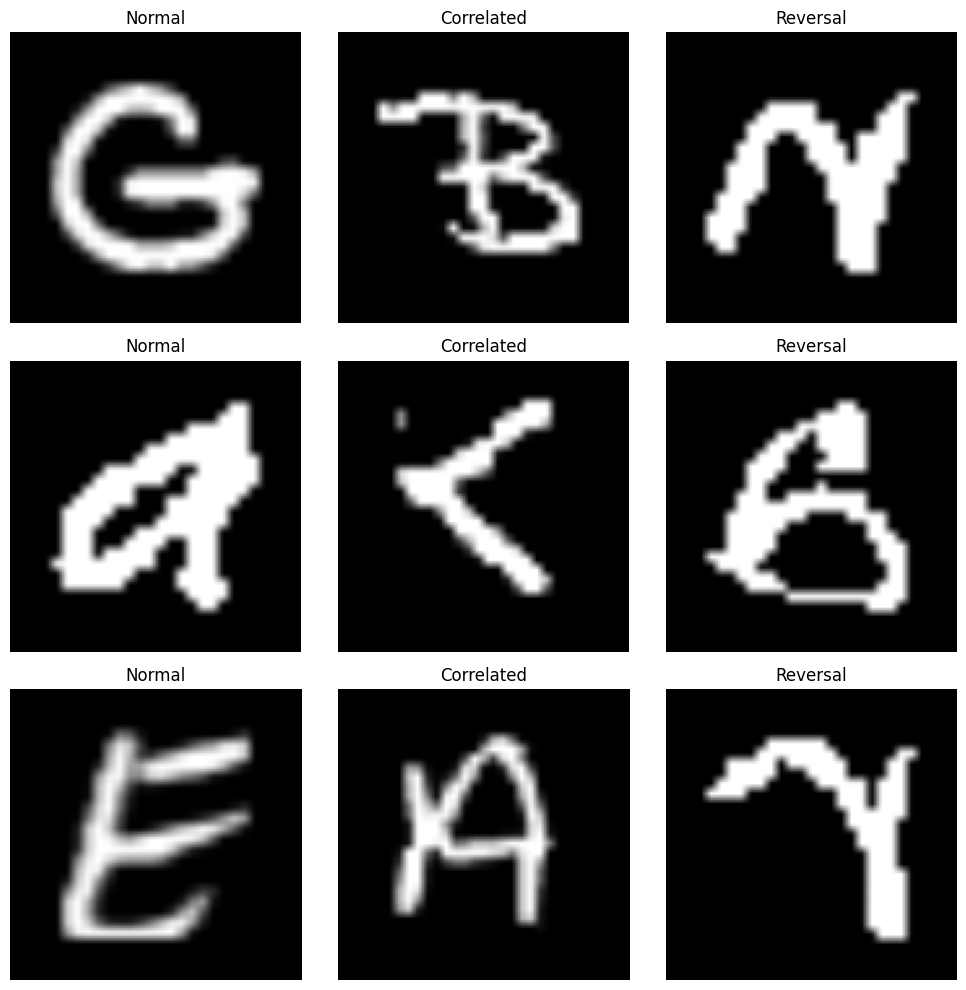

In [24]:
# Show a graph from each dataset
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

pics = [
    train_data_normal[0]['data'],
    train_data_correlated[1]['data'],
    train_data_reversal[2]['data'],
    train_data_normal[3]['data'],
    train_data_correlated[4]['data'],
    train_data_reversal[5]['data'],
    train_data_normal[6]['data'],
    train_data_correlated[7]['data'],
    train_data_reversal[8]['data']
]

titles = [
    "Normal",
    "Correlated",
    "Reversal",
    "Normal",
    "Correlated",
    "Reversal",
    "Normal",
    "Correlated",
    "Reversal"
]

for i, (pic, title) in enumerate(zip(pics, titles)):
    ax = axes[i // 3, i % 3]
    ax.imshow(pic, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [25]:
print(f"normal image shape: {train_data_normal.shape}\n correlated shape: {train_data_correlated.shape} \n reversal shape: {train_data_reversal.shape}")


normal image shape: (4916,)
 correlated shape: (4916,) 
 reversal shape: (4916,)


### **Data Preparation**

In [27]:
# Shuffle the order of defect-free and defect images
np.random.shuffle(train_data_normal)
np.random.shuffle(train_data_correlated)
np.random.shuffle(train_data_reversal)

# The class size is the minimum length compared with defect-free and defect images
class_size = min(train_data_normal.shape[0], train_data_correlated.shape[0], train_data_reversal.shape[0])

# Create dataset
dataset = np.concatenate((train_data_normal[:class_size], train_data_correlated[:class_size], train_data_reversal[:class_size]))

# Create an empty matrix X with a shape of (dataset length, 112, 112)
X = np.empty([dataset.shape[0], 112, 112]).astype(int)

# Create vector y which has dataset length
y = np.empty(dataset.shape[0]).astype(int)

# Assign the X, y one-by-one
for i in range(dataset.shape[0]):
    X[i] = dataset[i]["data"]
    y[i] = dataset[i]["label"]

# Reshape X for Keras (assuming Keras input is a tensor type)
X = X.reshape(X.shape[0], 112, 112, 1)

# Display size of the label 0 and label 1
np.unique(y, return_counts=True)


(array([0, 1, 2]), array([4916, 4916, 4916]))

### Split the Dataset into Training and Testing Part

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42)
print(
    f"y_train: number of samples each class: {np.unique(y_train, return_counts=True)}")

print(
    f"y_test: number of samples each class: {np.unique(y_test, return_counts=True)}")

y_train: number of samples each class: (array([0, 1, 2]), array([4421, 4410, 4442]))
y_test: number of samples each class: (array([0, 1, 2]), array([495, 506, 474]))


In [30]:
# Normalize the inputs from 0-255 to between 0 and 1 by dividing by 255
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

In [31]:
# One-hot encode outputs
from keras.utils import to_categorical
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)
class_num = Y_test.shape[1]
class_num

2024-03-30 10:04:20.561102: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


3

## **Deep Learning Approach**

- Build CNN Model to predict the dyslexia disease

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras import layers, models, optimizers, regularizers, callbacks

2024-03-28 22:30:12.326533: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### **Build The Model architecture**

In [20]:
def create_model(image_shape=(112, 112, 1), print_summary=False):
    # initial model
    model = models.Sequential()

    # CONV layer: filter 16, stride 7x7
    model.add(layers.Conv2D(filters = 16,kernel_size = (7,7),input_shape=image_shape,activation = 'relu',padding = 'same'))
    # Batch Normalization layer -> avoid overfitting
    model.add(layers.BatchNormalization())
    # activation layer
    model.add(layers.Activation('relu'))
    # max pooling -> reduce image size
    model.add(layers.MaxPooling2D((2, 2)))
    # droput later -> avoid overfitting
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(32, (5, 5), padding="same"))
    # Batch Normalization layer -> avoid overfitting
    model.add(layers.BatchNormalization())
    # activation layer
    model.add(layers.Activation('relu'))
    # max pooling -> reduce image size
    model.add(layers.MaxPooling2D((2, 2)))
    # droput later -> avoid overfitting
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, (3, 3), padding="same"))
    # Batch Normalization layer -> avoid overfitting
    model.add(layers.BatchNormalization())
    # activation layer
    model.add(layers.Activation('relu'))
    # max pooling -> reduce image size
    model.add(layers.MaxPooling2D((2, 2)))
    # droput later -> avoid overfitting
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, (3, 3), padding="same"))
    # Batch Normalization layer -> avoid overfitting
    model.add(layers.BatchNormalization())
    # activation layer
    model.add(layers.Activation('relu'))
    # max pooling -> reduce image size
    model.add(layers.MaxPooling2D((2, 2)))
    # droput later -> avoid overfitting
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, (3, 3), padding="same"))
    # Batch Normalization layer -> avoid overfitting
    model.add(layers.BatchNormalization())
    # activation layer
    model.add(layers.Activation('relu'))
    # max pooling -> reduce image size
    model.add(layers.MaxPooling2D((2, 2)))
    # droput later -> avoid overfitting
    model.add(layers.Dropout(0.25))

    # flatten later -> from matrix to vector
    model.add(layers.Flatten())

    # fully connected layer -> nn layer with 64 nodes
    model.add(layers.Dense(64))
    # Batch Normalization layer -> avoid overfitting
    model.add(layers.BatchNormalization())
    # activation layer
    model.add(layers.Activation('relu'))
    # droput later -> avoid overfitting
    model.add(layers.Dropout(0.25))

    # output layer
    model.add(layers.Dense(3, activation='softmax'))

    # set model compiler
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # show the CNN model detail
    if print_summary:
        model.summary()
    return model

create_model(image_shape=(112, 112, 1), print_summary=True)

/home/jawad/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 112, 112, 16)   │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 56, 56, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 56, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 218,371 (853.01 KB)

 Trainable params: 217,635 (850.14 KB)

 Non-trainable params: 736 (2.88 KB)

<Sequential name=sequential, built=True>

In [21]:
cnn_model = None
cnn_model = create_model(image_shape=(112, 112, 1))

#### Train the model 
In order to train the model the fit() function is called and pass in the chosen parameters.

In [22]:
history = cnn_model.fit(X_train, Y_train,  batch_size=16, epochs=10)

Epoch 1/10


2024-03-26 23:28:55.082161: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 665986048 exceeds 10% of free system memory.


830/830 ━━━━━━━━━━━━━━━━━━━━ 490s 568ms/step - accuracy: 0.6858 - loss: 0.7327
Epoch 2/10
830/830 ━━━━━━━━━━━━━━━━━━━━ 443s 534ms/step - accuracy: 0.8910 - loss: 0.3061
Epoch 3/10
830/830 ━━━━━━━━━━━━━━━━━━━━ 369s 444ms/step - accuracy: 0.9108 - loss: 0.2489
Epoch 4/10
830/830 ━━━━━━━━━━━━━━━━━━━━ 469s 565ms/step - accuracy: 0.9244 - loss: 0.2030
Epoch 5/10
830/830 ━━━━━━━━━━━━━━━━━━━━ 472s 568ms/step - accuracy: 0.9341 - loss: 0.1843
Epoch 6/10
830/830 ━━━━━━━━━━━━━━━━━━━━ 470s 566ms/step - accuracy: 0.9371 - loss: 0.1709
Epoch 7/10
830/830 ━━━━━━━━━━━━━━━━━━━━ 418s 504ms/step - accuracy: 0.9383 - loss: 0.1629
Epoch 8/10
830/830 ━━━━━━━━━━━━━━━━━━━━ 465s 560ms/step - accuracy: 0.9480 - loss: 0.1479
Epoch 9/10
830/830 ━━━━━━━━━━━━━━━━━━━━ 471s 568ms/step - accuracy: 0.9528 - loss: 0.1297
Epoch 10/10
830/830 ━━━━━━━━━━━━━━━━━━━━ 301s 362ms/step - accuracy: 0.9609 - loss: 0.1160


In [23]:
# save trained model and also its history
from keras.models import save_model
save_model(cnn_model, "best_model.h5")
np.save('my_history.npy',history.history)

#### **Load Model**

In [20]:
from numpy import loadtxt
from keras.models import load_model
import numpy as np
model = load_model('best_model.h5')
history=np.load('my_history.npy',allow_pickle='TRUE').item()
# summarize model.
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 16)   │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 112, 112, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 56, 56, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 218,373 (853.02 KB)

 Trainable params: 217,635 (850.14 KB)

 Non-trainable params: 736 (2.88 KB)

 Optimizer params: 2 (12.00 B)

### **Validate Trained Model**

In [21]:
# Model evaluation
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 96.75%


In [22]:
from sklearn.metrics import classification_report
predIdxs = model.predict(X_test)
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(y_test, predIdxs))

47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step
              precision    recall  f1-score   support

           0       0.92      0.99      0.96       495
           1       0.99      0.92      0.96       506
           2       0.99      0.99      0.99       474

    accuracy                           0.97      1475
   macro avg       0.97      0.97      0.97      1475
weighted avg       0.97      0.97      0.97      1475



In [24]:
import sklearn.metrics as metrics
confusion_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=predIdxs)
confusion_matrix

array([[493,   1,   1],
       [ 35, 464,   7],
       [  2,   2, 470]])

<Axes: >

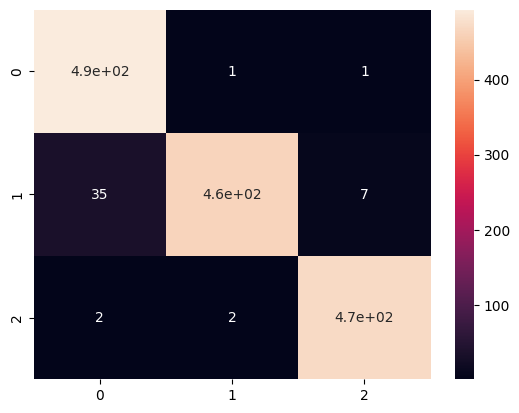

In [25]:
#Plot Confusion Matrix
import seaborn as sns
sns.heatmap(confusion_matrix, annot=True)

<Axes: >

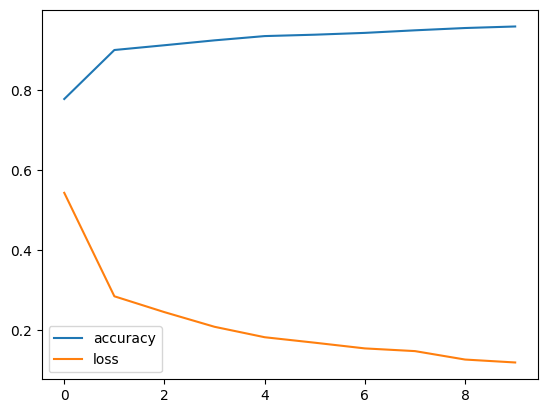

In [26]:
import pandas as pd
pd.DataFrame(history).plot()

### **Testing The Model**
Take a sample image from the dataset and pass it to the model in order to check the model is accurately predicting or not

In [23]:
from keras.preprocessing import image

In [113]:
def predictImage(filename):
    img1 = filename
    plt.imshow(img1)
    Y = image.img_to_array(img1)
    X = np.expand_dims(Y,axis=0)
    val = model.predict(X.reshape((1,112,112,1)))
    val=list(val[0])
    mx=max(val)
    print(f'{mx*100:.2f}% Accurate')
    val = val.index(mx)
    print(f'Label Index is {val}')
    if val == 0:
        plt.xlabel("Normal",fontsize=30)
    elif val == 1:
        plt.xlabel("Correlated",fontsize=30)
    elif val == 2:
        plt.xlabel("Reversal",fontsize=30)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
100.00% Accurate
Label Index is 1


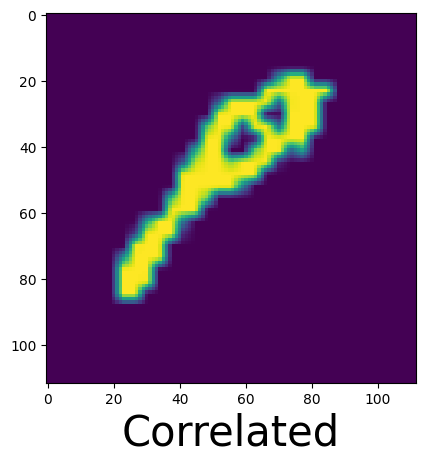

In [25]:
predictImage(X_train[100])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


99.99% Accurate
Label Index is 0


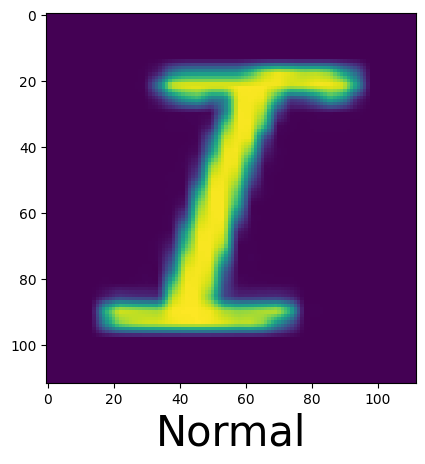

In [26]:
predictImage(X_test[10])

### Read Unseen Image from website touch canvas and predict result

In [170]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


# Function to make predictions
def predictImage(image_path, model):
    # Open the original image
    original_image = Image.open(image_path)

    # Resize the image while preserving the text
    img = original_image.resize((112, 112))

    # Plot the image
    plt.imshow(img)

    # Convert the image to grayscale
    img_gray = img.convert('L')

    # Prepare the image for prediction
    X = np.array(img_gray)
    X = np.expand_dims(X, axis=0)
    X = np.expand_dims(X, axis=-1)  # Add an extra dimension for the grayscale channel

    # Normalize the image data
    X = X.astype('float32') / 255.0

    # Make predictions
    val = model.predict(X)
    val = list(val[0])
    mx = max(val)
    print(f'{mx*100:.2f}% Accurate')
    label_index = val.index(mx)
    print(f'Label Index is {label_index}')
    if label_index == 0:
        plt.xlabel("Normal", fontsize=30)
    elif label_index == 1:
        plt.xlabel("Correlated", fontsize=30)
    elif label_index == 2:
        plt.xlabel("Reversal", fontsize=30)

    plt.show()


#### Convert and read image of canvas image

In [236]:
import numpy as np
import cv2

# Load the original image using OpenCV
original_image = cv2.imread("imresizer-1711647452478.png", cv2.IMREAD_UNCHANGED)


# Create a black background image
new_image = np.zeros((28, 28, 4), dtype=np.uint8)

# Calculate the position to paste the resized image
x_offset = (new_image.shape[1] - original_image.shape[1]) // 2
y_offset = (new_image.shape[0] - original_image.shape[0]) // 2

# Paste the resized image onto the black background
new_image[y_offset:y_offset+original_image.shape[0], x_offset:x_offset+original_image.shape[1]] = original_image

# Invert the colors (to make background black and text white)
inverted_image = cv2.bitwise_not(cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY))

# Save the modified image
cv2.imwrite("modified.png", inverted_image)


True

In [237]:
from PIL import Image

# Image path
image_path = 'modified.png'

# Open the image using PIL
image = Image.open(image_path)

# Get the dimensions and other properties of the image
image_info = {
    "Format": image.format,
    "Mode": image.mode,
    "Size": image.size
}

# Display image properties
print("Image Information:")
for key, value in image_info.items():
    print(f"{key}: {value}")

# Display the image
image.show()


Image Information:
Format: PNG
Mode: L
Size: (28, 28)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


68.74% Accurate
Label Index is 2


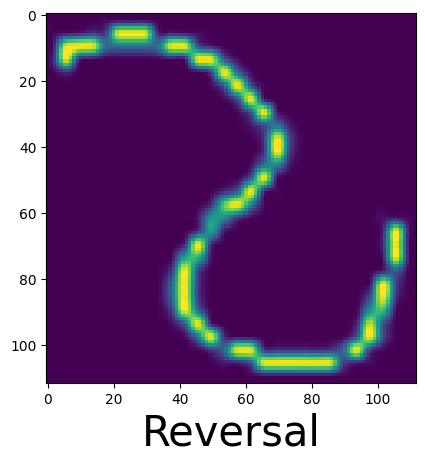

In [238]:
image_path = 'modified.png'
# Make predictions
predictImage(image_path, model)

## **Machine Learning Approach**

In [32]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report

In [33]:
# Initialize individual classifiers
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)

In [34]:
# Create the ensemble model using Voting Classifier
ensemble_classifier = VotingClassifier(estimators=[
    ('random_forest', rf_classifier),
    ('gradient_boosting', gb_classifier)
], voting='hard')  # 'hard' voting means majority voting

In [35]:
# Flatten the images for machine learning models
X_train_flatten = X_train.reshape(X_train.shape[0], -1)
X_test_flatten = X_test.reshape(X_test.shape[0], -1)

In [36]:
# Fit the ensemble model
ensemble_classifier.fit(X_train_flatten, y_train)

VotingClassifier(estimators=[('random_forest',
                              RandomForestClassifier(random_state=42)),
                             ('gradient_boosting',
                              GradientBoostingClassifier(random_state=42))])

In [37]:
# Predictions on the test set
y_pred = ensemble_classifier.predict(X_test_flatten)

In [38]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.9023728813559322
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       495
           1       0.93      0.88      0.90       506
           2       0.92      0.87      0.89       474

    accuracy                           0.90      1475
   macro avg       0.90      0.90      0.90      1475
weighted avg       0.90      0.90      0.90      1475



In [39]:
import pickle

# Save the trained ensemble model
with open('ensemble_model_weights.pkl', 'wb') as f:
    pickle.dump(ensemble_classifier, f)


In [40]:
# Load the saved ensemble model
with open('ensemble_model_weights.pkl', 'rb') as f:
    ensemble_classifier_loaded = pickle.load(f)

In [42]:
# To predict a single unseen image, you need to flatten and normalize it as well
pic = cv2.imread('imresizer-1711647452478.png', 0)
img = cv2.resize(pic, (112, 112))
img_flat = img.flatten().astype('float32') / 255.0
predicted_class = ensemble_classifier_loaded.predict(img_flat.reshape(1, -1))
print("Predicted class:", predicted_class)


Predicted class: [2]
